In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow import keras as keras
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification


from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Minh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('repos.whole.csv')
df = df[['description', 'label']]
df['label'] = df['label'].astype(int)
df['description'] = df['description'].astype(str)

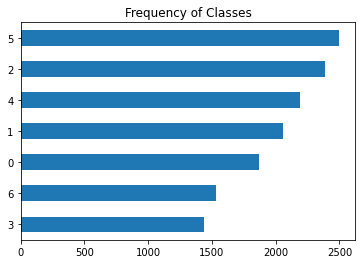

In [ ]:
df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

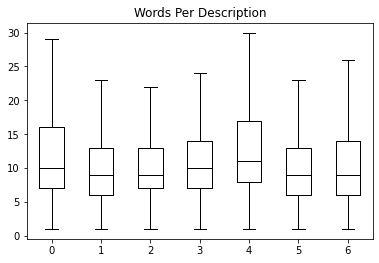

In [ ]:
df["Words Per Description"] = df["description"].str.split().apply(len)
df.boxplot("Words Per Description", by="label", grid=False,
 showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [5]:
train_set, temp_set = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=0.5, stratify=temp_set['label'], random_state=42)

# LSTM training

In [6]:
lstm_train_set = train_set.copy()
lstm_test_set = test_set.copy()
lstm_val_set = val_set.copy()
# label encoding
lstm_train_y = to_categorical(lstm_train_set['label'], num_classes=7)
lstm_val_y = to_categorical(lstm_val_set['label'], num_classes=7)
lstm_test_y = to_categorical(lstm_test_set['label'], num_classes=7)

In [7]:
# data preprocessing

# convert description to str
lstm_train_set['description'] = lstm_train_set['description'].astype(str)
lstm_test_set['description'] = lstm_test_set['description'].astype(str)

lstm_train_set['description'] = lstm_train_set['description'].apply(lambda x :x.lower())
lemm = WordNetLemmatizer()
lstm_train_set['description'] = lstm_train_set['description'].apply(lambda x: lemm.lemmatize(x))

lstm_val_set['description'] = lstm_val_set['description'].apply(lambda x :x.lower())
lemm = WordNetLemmatizer()
lstm_val_set['description'] = lstm_val_set['description'].apply(lambda x: lemm.lemmatize(x))

lstm_test_set['description'] = lstm_test_set['description'].apply(lambda x :x.lower())
lemm = WordNetLemmatizer()
lstm_test_set['description'] = lstm_test_set['description'].apply(lambda x: lemm.lemmatize(x))

In [8]:
# tokenizer
lstm_train_token = Tokenizer(num_words=10000,oov_token="<OOV>",
                  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
lstm_train_token.fit_on_texts(lstm_train_set['description'])
lstm_train_word_index = lstm_train_token.word_index
lstm_train_seq = lstm_train_token.texts_to_sequences(lstm_train_set['description'])

lstm_val_token = Tokenizer(num_words=10000,oov_token="<OOV>",
                  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
lstm_val_token.fit_on_texts(lstm_train_set['description'])
lstm_val_word_index = lstm_val_token.word_index
lstm_val_seq = lstm_val_token.texts_to_sequences(lstm_val_set['description'])

lstm_test_token = Tokenizer(num_words=10000,oov_token="<OOV>",
                  filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~')
lstm_test_token.fit_on_texts(lstm_train_set['description'])
lstm_test_word_index = lstm_test_token.word_index
lstm_test_seq = lstm_test_token.texts_to_sequences(lstm_test_set['description'])

In [9]:
# Padding
lstm_train_padd = pad_sequences(lstm_train_seq,padding="post",truncating="post",maxlen=35)
lstm_val_padd = pad_sequences(lstm_val_seq,padding="post",truncating="post",maxlen=35)
lstm_test_padd = pad_sequences(lstm_test_seq,padding="post",truncating="post",maxlen=35)

In [10]:
# Model
lstm_model = keras.models.Sequential()

lstm_model.add(keras.layers.Embedding(30000,128))

lstm_model.add(keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True, dropout=0.3)))

lstm_model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.3)))

lstm_model.add(keras.layers.Dense(128,activation="gelu"))

lstm_model.add(keras.layers.Dropout(0.3))

lstm_model.add(keras.layers.Dense(7,activation="softmax"))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         3840000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 9

In [13]:
callbacks = [EarlyStopping(monitor='val_loss',patience=6, min_delta=0.01)]

history = lstm_model.fit(lstm_train_padd, lstm_train_y, epochs=30, batch_size=64,
                    validation_data=(lstm_val_padd, lstm_val_y), callbacks=callbacks)

Epoch 1/30
132/132 [==============================] - 3s 19ms/step - loss: 0.1055 - accuracy: 0.9634 - val_loss: 0.5525 - val_accuracy: 0.8594
Epoch 2/30
132/132 [==============================] - 2s 18ms/step - loss: 0.0998 - accuracy: 0.9623 - val_loss: 0.6214 - val_accuracy: 0.8548
Epoch 3/30
132/132 [==============================] - 2s 17ms/step - loss: 0.0896 - accuracy: 0.9648 - val_loss: 0.5694 - val_accuracy: 0.8569
Epoch 4/30
132/132 [==============================] - 2s 18ms/step - loss: 0.0874 - accuracy: 0.9628 - val_loss: 0.6574 - val_accuracy: 0.8544
Epoch 5/30
132/132 [==============================] - 2s 17ms/step - loss: 0.0770 - accuracy: 0.9666 - val_loss: 0.6863 - val_accuracy: 0.8573
Epoch 6/30
132/132 [==============================] - 2s 18ms/step - loss: 0.0733 - accuracy: 0.9673 - val_loss: 0.6861 - val_accuracy: 0.8609
Epoch 7/30
132/132 [==============================] - 2s 18ms/step - loss: 0.0713 - accuracy: 0.9676 - val_loss: 0.7122 - val_accuracy: 0.8494

In [14]:
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(lstm_test_padd,lstm_test_y)

print(f'Test Loss: {lstm_test_loss}')
print(f'Test Accuracy: {lstm_test_accuracy}')

88/88 [==============================] - 1s 8ms/step - loss: 0.6460 - accuracy: 0.8662
Test Loss: 0.6460420489311218
Test Accuracy: 0.866237461566925


# Distill Bert training

In [15]:
model_ckpt = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
d_bert_model = (TFDistilBertForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=len(df['label'].unique())))


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_20', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [16]:
def encode_data(tokenizer, text, max_length):
    return tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='tf'
    )

MAX_LENGTH = 36
d_bert_train_encodings = encode_data(tokenizer, train_set['description'].tolist(), MAX_LENGTH)
d_bert_test_encodings = encode_data(tokenizer, test_set['description'].tolist(), MAX_LENGTH)
d_bert_val_encodings = encode_data(tokenizer, val_set['description'].tolist(), MAX_LENGTH)

d_bert_train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(d_bert_train_encodings),
    train_set['label'].tolist()
))

d_bert_test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(d_bert_test_encodings),
    test_set['label'].tolist()
))

d_bert_val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(d_bert_val_encodings),
    val_set['label'].tolist()
))

BATCH_SIZE = 32 
d_bert_train_dataset = d_bert_train_dataset.shuffle(len(train_set)).batch(BATCH_SIZE).repeat(-1)
d_bert_val_dataset = d_bert_val_dataset.batch(BATCH_SIZE)
d_bert_test_dataset = d_bert_test_dataset.batch(BATCH_SIZE)

d_bert_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Minh\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
d_bert_model.compile(optimizer=d_bert_optimizer, loss=d_bert_model.compute_loss, metrics=['accuracy'])
history = d_bert_model.fit(
    d_bert_train_dataset,
    epochs=16,
    steps_per_epoch=len(train_set) // BATCH_SIZE,
    validation_data=d_bert_val_dataset,
    validation_steps=len(val_set) // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/16


C:\Users\Minh\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\autograph\impl\api.py:377: FutureWarning: The old compute_loss method is deprecated as it conflicts with the Keras compute_loss method added in TF 2.8. If you want the original HF compute_loss, please call hf_compute_loss() instead. From TF versions >= 2.8, or Transformers versions >= 5, calling compute_loss() will get the Keras method instead.
  return py_builtins.overload_of(f)(*args)


262/262 [==============================] - 29s 90ms/step - loss: 0.1853 - accuracy: 0.9442 - val_loss: 0.3793 - val_accuracy: 0.8908
Epoch 2/16
262/262 [==============================] - 23s 86ms/step - loss: 0.1564 - accuracy: 0.9514 - val_loss: 0.4003 - val_accuracy: 0.8940
Epoch 3/16
262/262 [==============================] - 22s 86ms/step - loss: 0.1410 - accuracy: 0.9565 - val_loss: 0.4284 - val_accuracy: 0.8815
Epoch 4/16
262/262 [==============================] - 23s 86ms/step - loss: 0.1179 - accuracy: 0.9600 - val_loss: 0.4431 - val_accuracy: 0.8811
Epoch 5/16
262/262 [==============================] - 23s 86ms/step - loss: 0.1112 - accuracy: 0.9617 - val_loss: 0.4741 - val_accuracy: 0.8718
Epoch 6/16
262/262 [==============================] - 23s 87ms/step - loss: 0.0958 - accuracy: 0.9642 - val_loss: 0.4713 - val_accuracy: 0.8790
Epoch 7/16
262/262 [==============================] - 23s 87ms/step - loss: 0.0894 - accuracy: 0.9654 - val_loss: 0.5071 - val_accuracy: 0.8718


In [22]:
d_bert_test_loss, d_bert_test_accuracy = d_bert_model.evaluate(d_bert_test_dataset)

print(f'Test Loss: {d_bert_test_loss}')
print(f'Test Accuracy: {d_bert_test_accuracy}')

88/88 [==============================] - 3s 28ms/step - loss: 0.4591 - accuracy: 0.8798
Test Loss: 0.4591134190559387
Test Accuracy: 0.8798283338546753


In [23]:
def get_predictions(model, dataset):
    all_labels = []
    all_predictions = []
    
    for batch in dataset:
        inputs = batch[0]
        labels = batch[1].numpy()
        predictions = np.argmax(model(inputs, training=False).logits, axis=1)
        
        all_labels.extend(labels)
        all_predictions.extend(predictions)
    
    return np.array(all_labels), np.array(all_predictions)

true_labels, predicted_labels = get_predictions(d_bert_model, d_bert_test_dataset)

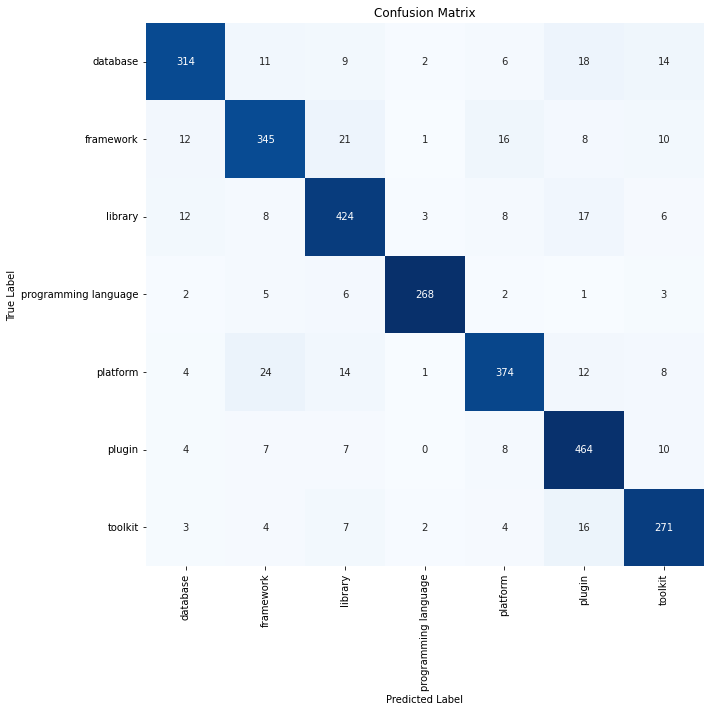

In [25]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    sns.heatmap(cm_normalized, annot=cm, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['database', 'framework', 'library', 'programming language', 'platform', 'plugin', 'toolkit']  # Replace this with your actual class names

plot_confusion_matrix(true_labels, predicted_labels, class_names)

In [12]:
from performance_benchmark import PerformanceBenchmark

benchmark = PerformanceBenchmark(d_bert_model, tokenizer, d_bert_test_dataset, optim_type="DistilBert")
metrics = benchmark.run_benchmark()
print(metrics)

{'DistilBert': {'accuracy': 0.8866237482117311, 'model_size': 66958855, 'time_taken': 0.05701398849487305}}


In [1]:
# save 
save_directory = "saved_model/distilbert_github_app_classification_v1"
d_bert_model.save_pretrained(save_directory)

NameError: name 'd_bert_model' is not defined

# Knowledge Distillation


In [13]:
# import numpy as np
# from transformers import TFDistilBertForSequenceClassification, TFBertForSequenceClassification, DistilBertTokenizerFast, AutoConfig
# from transformers import DistilBertConfig
# from transformers import TFTrainer, TFTrainingArguments
# from sklearn.metrics import accuracy_score


In [14]:
# student_ckpt = "distilbert-base-uncased"
# student_model = (TFDistilBertForSequenceClassification
#                 .from_pretrained(student_ckpt, num_labels=len(df['label'].unique())))
# teacher_ckpt ="bert-base-uncased"
# teacher_model = (TFBertForSequenceClassification
#                 .from_pretrained(teacher_ckpt, num_labels=len(df['label'].unique())))

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use i

In [15]:
# # fine-tuned teacher

# teacher_training_args = TFTrainingArguments(
#     output_dir='./res/training_res/',
#     num_train_epochs=3,
#     per_device_train_batch_size=BATCH_SIZE,
#     per_device_eval_batch_size=BATCH_SIZE,
#     weight_decay=0.01,
#     logging_dir='./log/training_log/',
# )

# def compute_metrics(eval_preds):
#     logits, labels = eval_preds
#     preds = tf.argmax(logits, axis=-1).numpy()
#     accuracy = accuracy_score(labels, preds)
#     return {"accuracy": accuracy}

# # Create the Trainer
# teacher_trainer = TFTrainer(
#     model=teacher_model,
#     args=teacher_training_args,
#     train_dataset=train_dataset,
#     eval_dataset=val_dataset,
#     compute_metrics=compute_metrics,
# )

# # Train the model
# teacher_trainer.train()

# # Evaluate the model
# teacher_trainer.evaluate()

c:\Users\Minh\anaconda3\lib\site-packages\transformers\trainer_tf.py:115: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: minhucincy (use `wandb login --relogin` to force relogin)
